In [ ]:
!pip install praw pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install asyncpraw pandas nest_asyncio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import asyncpraw
import pandas as pd
import nest_asyncio
import asyncio


nest_asyncio.apply()

# Reddit API credentials
reddit = asyncpraw.Reddit(
    client_id='ZxWOSvpXx9EhQWFl3iPZtA',
    client_secret='F-zTBaCWdMe6Hv5dgJjYd3vOMAF86w',
    user_agent='electric_vehicle_data_collector:v1.0 (by /u/w1923645)'
)


In [ ]:
# Keywords for searching posts
keywords = ["fully electric vehicle", "electric car", "Tesla Model 3", "Nissan Leaf",
            "EV ownership", "electric vehicle charging", "electric car range",
            "electric vehicle maintenance"]

# Asynchronous function to collect posts
async def collect_posts(reddit, keyword, limit=125):
    posts = []
    subreddit = await reddit.subreddit('all')
    async for submission in subreddit.search(keyword, limit=limit):
        posts.append([submission.title, submission.selftext, submission.created_utc, submission.score, submission.num_comments, submission.subreddit.display_name])
    return posts

# Asynchronous function to collect data for each keyword
async def collect_data():
    all_posts = []
    for keyword in keywords:
        posts = await collect_posts(reddit, keyword, limit=125)
        all_posts.extend(posts)
    return all_posts


In [ ]:
async def main():
    # Collect data
    all_posts = await collect_data()

    # Convert to DataFrame
    columns = ['Title', 'Text', 'Created_UTC', 'Score', 'Num_Comments', 'Subreddit']
    df = pd.DataFrame(all_posts, columns=columns)

    # Preprocessing steps
    # Remove duplicates
    df.drop_duplicates(subset=['Title', 'Text'], inplace=True)

    # Handle missing values
    df.dropna(subset=['Text'], inplace=True)

    # Basic text cleaning
    df['Text'] = df['Text'].str.replace('\n', ' ')
    df['Title'] = df['Title'].str.replace('\n', ' ')

    # Convert timestamp to datetime
    df['Created_UTC'] = pd.to_datetime(df['Created_UTC'], unit='s')

    # Show the preprocessed data
    print(df.head())

    # Check the total number of posts
    total_posts = df.shape[0]
    print(f'Total number of posts collected: {total_posts}')

    # Save the dataset to a CSV file for further use
    df.to_csv('electric_vehicle_reddit_posts.csv', index=False)

# Run the main function
await main()


                                               Title  \
0  Volvo Cars' sales of fully electric vehicles j...   
1  Fully Electric Vehicles Reached ~6% Of Auto Sa...   
2  Self-balancing, fully-enclosed electric motorc...   
3  Gov. Greg Abbott signs electric vehicle fee in...   
4                        Owning and Electric Vehicle   

                                                Text         Created_UTC  \
0  From the article:  "*STOCKHOLM, Nov 3 (Reuters... 2023-11-03 11:49:45   
1                                                    2022-10-15 04:52:37   
2                                                    2024-05-12 09:59:53   
3                                                    2023-05-18 19:12:07   
4                                                    2024-03-24 16:39:21   

   Score  Num_Comments         Subreddit  
0    260           102  electricvehicles  
1    396           272  electricvehicles  
2  14668           821          BeAmazed  
3  15429          2018        tech

In [ ]:
!pip install matplotlib seaborn wordcloud nltk


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime

# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load the dataset
df = pd.read_csv('electric_vehicle_reddit_posts.csv')

# Convert Created_UTC to datetime if not already done
df['Created_UTC'] = pd.to_datetime(df['Created_UTC'])

# Combine Title and Text for analysis
df['Content'] = df['Title'].fillna('') + ' ' + df['Text'].fillna('')

# Ensure all entries in 'Content' are strings
df['Content'] = df['Content'].astype(str)

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Content'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

# Generate a single list of all tokens
all_tokens = [token for sublist in df['Tokens'].tolist() for token in sublist]


           Word  Frequency
17          car        636
4      electric        543
552          ev        417
51      vehicle        384
105       tesla        318
482       model        270
246    charging        269
11            3        250
1370     nissan        222
1371       leaf        217
1          cars        215
249       would        200
62          new        189
344       range        184
229     battery        180
283       https        179
131        like        174
5      vehicles        174
76          one        163
1161  ownership        160


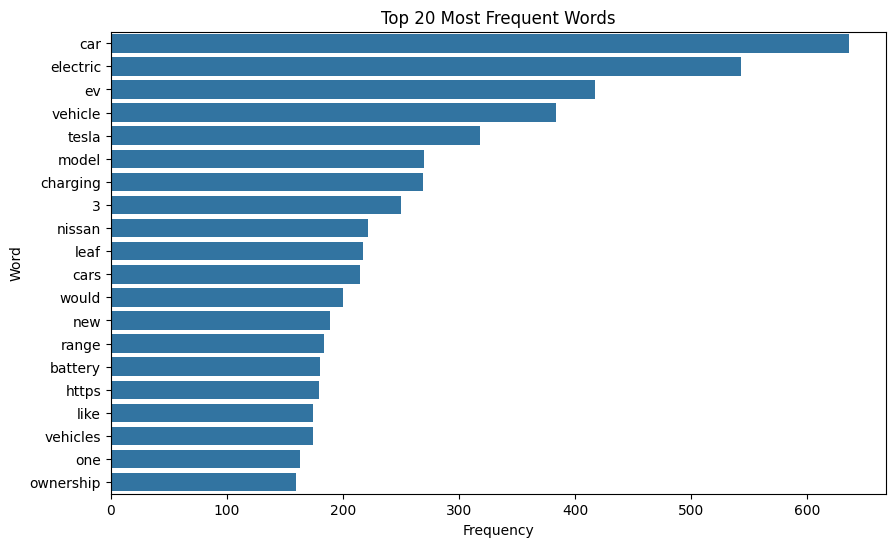

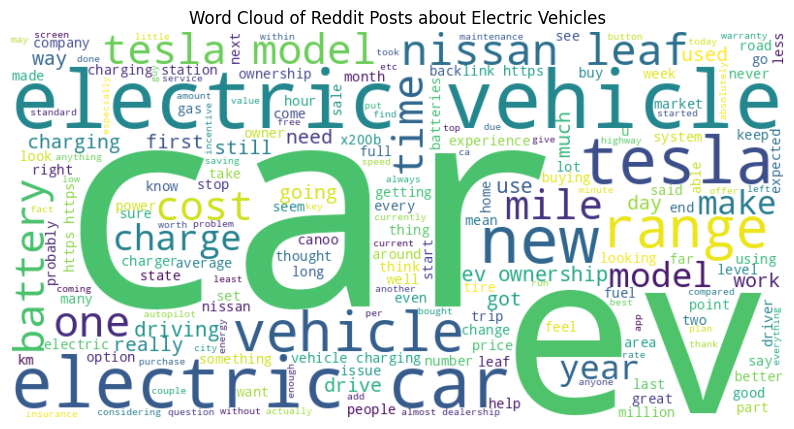

In [ ]:
# Count the frequency of each word
word_freq = Counter(all_tokens)

# Create a DataFrame for word frequency
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 20 most frequent words
top_words = word_freq_df.head(20)
print(top_words)

# Visualization of the most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_words)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reddit Posts about Electric Vehicles')
plt.show()


                     Bigram  Frequency
1511             (model, 3)        198
72      (electric, vehicle)        165
2658         (nissan, leaf)        163
1510         (tesla, model)        151
20          (electric, car)        120
2169        (ev, ownership)        100
4      (electric, vehicles)         99
33         (electric, cars)         86
362     (vehicle, charging)         79
2505          (link, https)         49
3821         (https, https)         44
363    (charging, stations)         38
4107          (3, highland)         18
5850         (ice, vehicle)         18
3         (fully, electric)         18
17294   (charging, network)         16
1858           (ev, owners)         16
6312       (fast, charging)         15
3521             (new, car)         15
12646          (car, range)         14


<ipython-input-13-604842ebaa97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_bigrams['Bigram'] = top_bigrams['Bigram'].apply(lambda x: ' '.join(x))


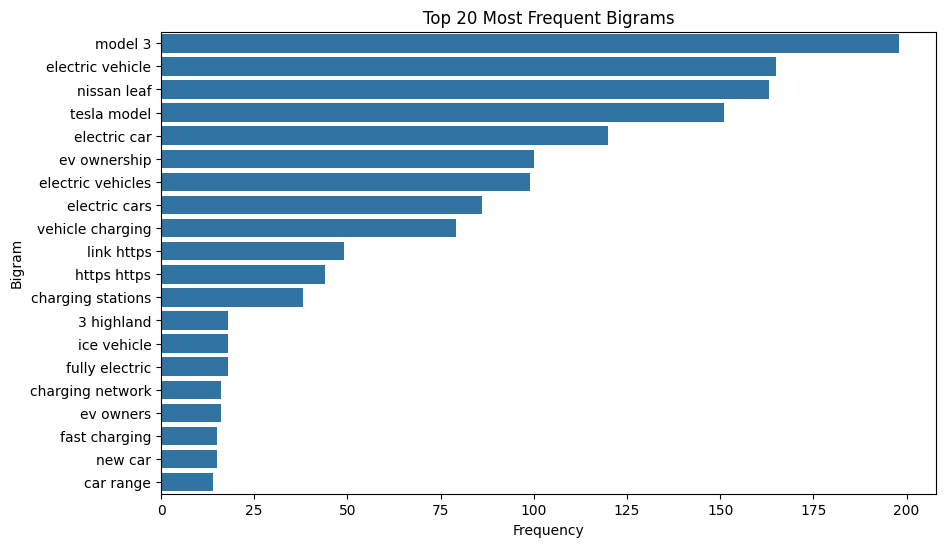

In [ ]:
# Create bigrams
bigrams = nltk.bigrams(all_tokens)
bigram_freq = Counter(bigrams)

# Convert bigrams to DataFrame
bigram_freq_df = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 20 most frequent bigrams
top_bigrams = bigram_freq_df.head(20)
print(top_bigrams)

# Visualization of the most frequent bigrams
top_bigrams['Bigram'] = top_bigrams['Bigram'].apply(lambda x: ' '.join(x))
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams)
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


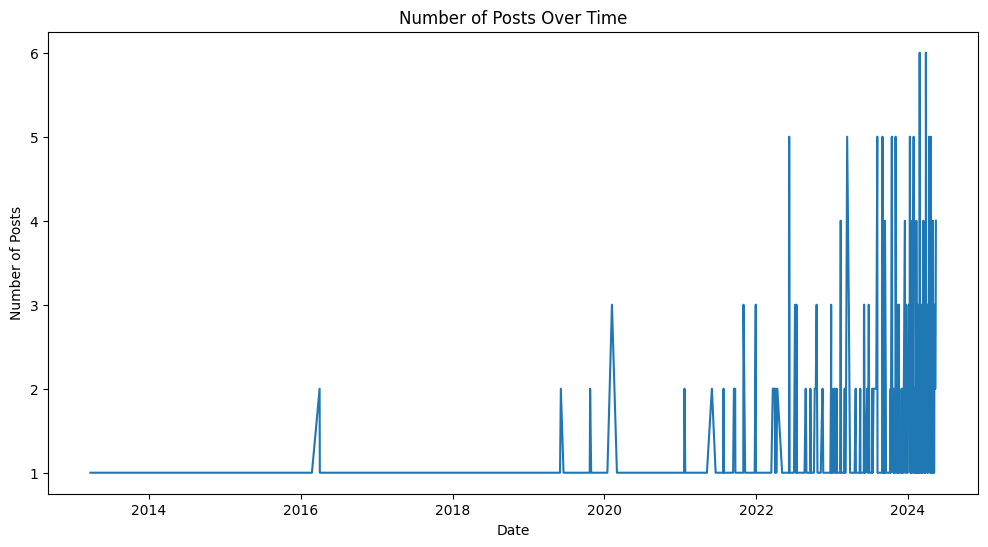

In [ ]:
# Group by date
df['Date'] = df['Created_UTC'].dt.date
date_counts = df.groupby('Date').size().reset_index(name='Count')

# Time-series plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Count', data=date_counts)
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()


In [ ]:
# Install necessary libraries
!pip install gensim pyLDAvis

# Import libraries
import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['Tokens'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in df['Tokens']]

# Train LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=2)

# Display the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Visualize the topics
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.8 MB/s eta 0:00:00
(0, '0.047*"car" + 0.019*"vehicles" + 0.019*"cars" + 0.018*"would" + 0.016*"like"')
(1, '0.056*"nissan" + 0.048*"leaf" + 0.047*"https" + 0.045*"vehicle" + 0.028*"ev"')
(2, '0.066*"car" + 0.028*"range" + 0.027*"battery" + 0.020*"miles" + 0.017*"vehicle"')
(3, '0.104*"ev" + 0.086*"charging" + 0.078*"vehicle" + 0.060*"ownership" + 0.024*"stations"')
(4, '0.136*"tesla" + 0.113*"model" + 0.100*"3" + 0.051*"cars" + 0.025*"car"')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.5 MB/s eta 0:00:00
Sentiment_Label
Neutral     311
Positive    275
Negative    168
Name: count, dtype: int64


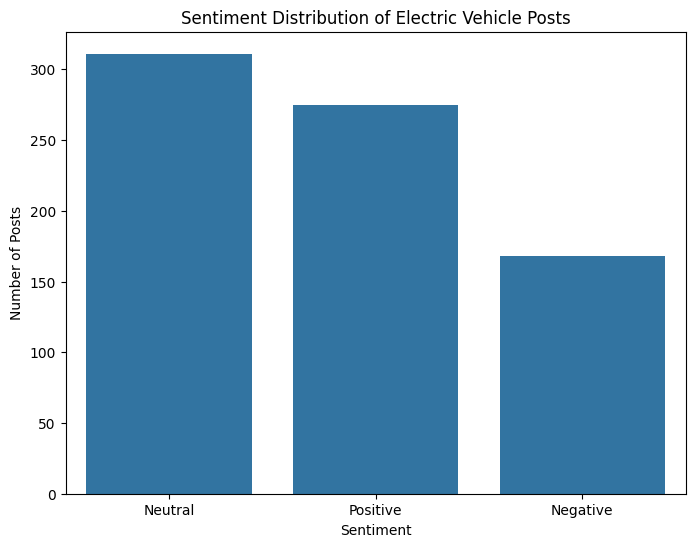

In [ ]:
# Install necessary libraries
!pip install vaderSentiment

# Import libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['Sentiment'] = df['Content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Classify sentiments
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Display sentiment distribution
sentiment_counts = df['Sentiment_Label'].value_counts()
print(sentiment_counts)

# Visualization
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_Label', data=df)
plt.title('Sentiment Distribution of Electric Vehicle Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()


In [ ]:
# Evaluate LDA model coherence
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=df['Tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

# Classification metrics for sentiment analysis
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(df['Sentiment_Label'], df['Sentiment_Label']))  # Placeholder for true labels if available


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.31669371852157474
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       168
     Neutral       1.00      1.00      1.00       311
    Positive       1.00      1.00      1.00       275

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'y_true' is not defined